# Imports

In [18]:
# imports, including functions provided with the starter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

os.chdir('..')

from groupXY_functions import *


# Defining functions and preprocessing

In [4]:
# Return smallest and largest x, smallest and largest y that contains a white pixel, so that we can crop it to measure asymmetry
def get_extremes(image):
    non_zeros = np.nonzero(image)
    return min(non_zeros[1]), max(non_zeros[1]), min(non_zeros[0]), max(non_zeros[0])

In [5]:
# Crops both the image and the mask to the actual size of the mask, saves to files
# Returns cropped image and mask in the array
def crop(image_id):
    path = 'data/example_image'
    path_cropped = path + '_cropped'
    path_mask = 'data/example_segmentation'
    path_mask_cropped = path_mask + '_cropped'
    if os.path.exists(path_cropped + image_id + '.jpg'):
        image = plt.imread(path_cropped + '/' + image_id + '.jpg')
        mask = plt.imread(path_mask_cropped + '/' + image_id + '.png')
        return image, mask
    if not os.path.exists(path_cropped):
        os.mkdir(path_cropped)
        os.mkdir(path_mask_cropped)
    image = plt.imread(path + '/' + image_id + '.jpg')
    mask = plt.imread(path_mask + '/' + image_id + '_segmentation.png')
    min_x, max_x, min_y, max_y = get_extremes(mask)
    mask = mask[min_y:max_y+1, min_x:max_x+1]
    plt.imsave(path_mask_cropped + '/' + image_id + '.png', mask, cmap=plt.cm.gray)
    image_cropped = image.copy()[min_y:max_y+1, min_x:max_x+1, :]
    to_black = mask==0
    image_cropped[to_black] = (0,0,0)
    plt.imsave(path_cropped + '/' + image_id + '.jpg', image_cropped)   
    return image, mask

In [6]:
# Assymetry function
# 0 is a perfect circle, 1 has all the quarters of an image completely different
def asymmetry_score(image):

    height, width = np.shape(image)
    if width % 2:
        # Subparts need to be the same size to compare them
        left_half = image[:, 0:width//2+1]
    else:
        left_half = image[:, 0:width//2]
    # "folding" on vertical axis
    right_half = np.flip(image[:, width//2:], 1)
    
    if height % 2:
        top_half = image[0:height//2+1, :]
    else:
        top_half = image[0:height//2, :]
    # "folding" on hotizontal axis
    bottom_half = np.flip(image[height//2:, :], 0)
    
    hor_diff = np.where(left_half != right_half, 1, 0)
    ver_diff = np.where(top_half != bottom_half, 1, 0)
    return round((np.sum(hor_diff) + np.sum(ver_diff)) / (width * height),3)

In [7]:
# Border function, compactness
# Due to inherit limitations of digital images, for some masks returend compactness value is below 1, which is wrong.
# Nonetheless, such an imprecission is acceptable given that multiple variables are considred in diagnoses 
def get_compactness(area, perimeter):
    return round(perimeter**2 / (4 * np.pi * area),3)

In [8]:
def colour_extraction (cropped_image):
    
    # split the image into its respective RGB components
    r, g, b = np.array_split(cropped_image, 3, 2)
    
    return r,g,b

def colour_variance_avg(r,g,b):
    return np.mean((np.var(r[r>0]),np.var(g[g>0]),np.var(b[b>0])))

In [9]:
# Import a data frame with file names and associated diseases
df_conditions = pd.read_csv('data/example_ground_truth.csv')


# A new datframe is created, which will store results of ABC tests 
df_evaluations = pd.DataFrame(df_conditions['image_id'])
for name in ['asymmetry', 'border', 'colour']:
    df_evaluations[name] = 0.0
    
for i in range(df_evaluations.shape[0]):
    image, mask = crop(df_evaluations.at[i, 'image_id'])
    df_evaluations.at[i, 'asymmetry'] = asymmetry_score(mask)
    area, perimeter = measure_area_perimeter(mask)
    df_evaluations.at[i, 'border'] = get_compactness(area, perimeter)
    r,g,b = colour_extraction(image)
    df_evaluations.at[i,'colour'] = colour_variance_avg(r,g,b)

# Standarisation of features' values

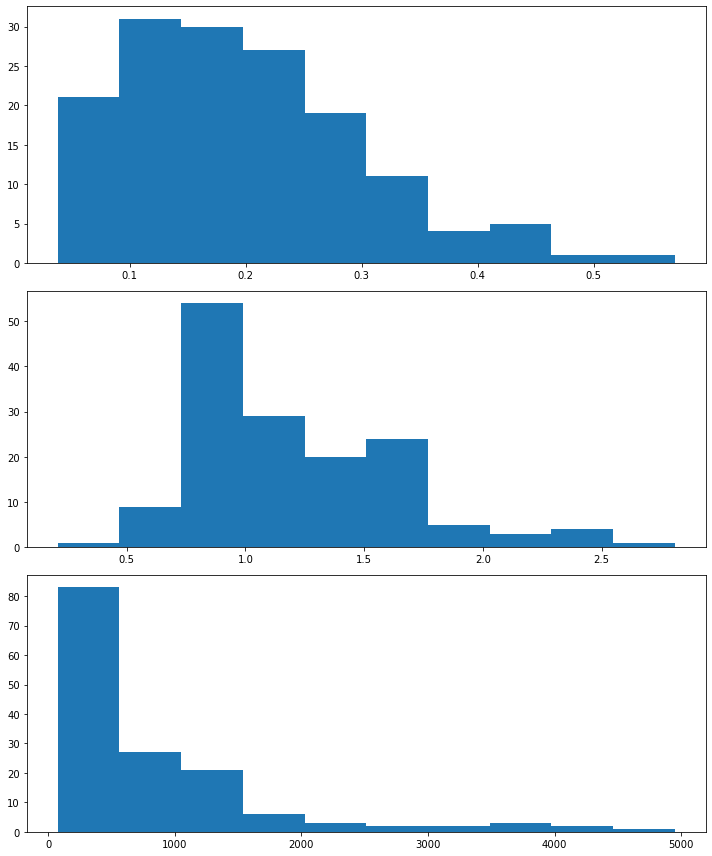

In [10]:
#data before standarisation
fig, axs = plt.subplots(3,figsize=(10,12))
axs[0].hist(df_evaluations['asymmetry'])
axs[1].hist(df_evaluations['border'])
axs[2].hist(df_evaluations['colour'])
fig.tight_layout()


In [11]:
df_evaluations

,image_id,asymmetry,border,colour
0,ISIC_0001769,0.195,1.458,618.627600
1,ISIC_0001852,0.126,0.984,447.253504
2,ISIC_0001871,0.259,0.999,1623.115145
3,ISIC_0003462,0.060,0.743,1412.217843
4,ISIC_0003539,0.416,1.058,306.096484
...,...,...,...,...
145,ISIC_0015443,0.099,1.180,1162.263646
146,ISIC_0015445,0.570,2.387,1805.319398
147,ISIC_0015483,0.072,1.445,1966.925779
148,ISIC_0015496,0.201,1.491,4029.559465


In [12]:
for name in ['asymmetry', 'border', 'colour']:
    mean = np.mean(df_evaluations[name])
    sd = np.std(df_evaluations[name])
    for i in range(df_evaluations.shape[0]):
        df_evaluations.at[i, name] = (df_evaluations.at[i, name] - mean) / sd

In [13]:
df_evaluations

,image_id,asymmetry,border,colour
0,ISIC_0001769,-0.023781,0.578983,-0.232156
1,ISIC_0001852,-0.709402,-0.476142,-0.420793
2,ISIC_0001871,0.612156,-0.442752,0.873516
3,ISIC_0003462,-1.365212,-1.012609,0.641374
4,ISIC_0003539,2.172190,-0.311418,-0.576170
...,...,...,...,...
145,ISIC_0015443,-0.977688,-0.039845,0.366242
146,ISIC_0015445,3.702415,2.646940,1.074074
147,ISIC_0015483,-1.245974,0.550045,1.251959
148,ISIC_0015496,0.035838,0.652441,3.522368


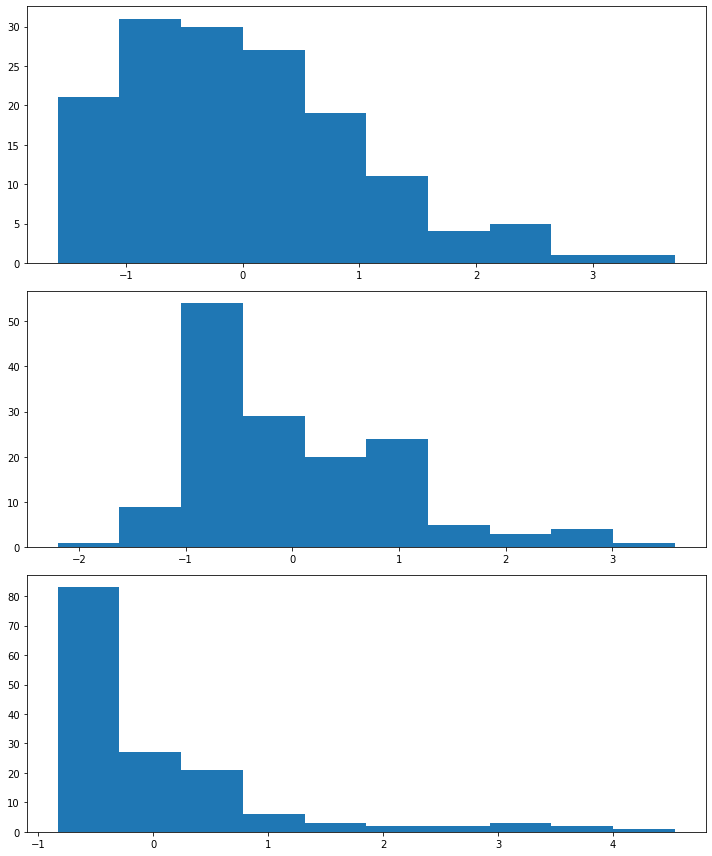

In [14]:
#data after standarisation
fig, axs = plt.subplots(3,figsize=(10,12))
axs[0].hist(df_evaluations['asymmetry'])
axs[1].hist(df_evaluations['border'])
axs[2].hist(df_evaluations['colour'])
fig.tight_layout()

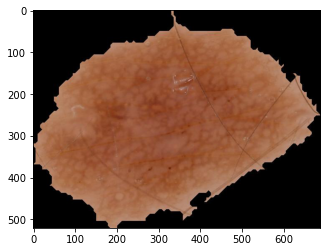

In [15]:
mask = plt.imread('data/example_segmentation/ISIC_0001769_segmentation.png')
image = plt.imread('data/example_image_cropped/ISIC_0001769.jpg')

plt.imshow(image)

In [16]:
##Loading data#

In [28]:
file_data = 'fyp2022-imaging/data/example_ground_truth.csv'
file_features = 'fyp2022-imaging/features/features.csv'

In [ ]:
df = df.drop(['image_id','seborrheic_keratosis'],axis=1)
df['area'] = features['area']
df['perimeter'] = features['perimeter']

print(df.head())

In [ ]:
##Feature selection##

In [ ]:
##Data Visualisation##

FileNotFoundError: [Errno 2] No such file or directory: 'fyp2022-imaging/data/ManualDataAnalysis.csv '